# Brillouin Peak Shift (BPS) Analysis and Modeling

This notebook performs analysis on Brillouin Peak Shift (BPS) data, generates synthetic data based on statistical analysis, trains a deep learning model to predict peak positions, and evaluates the model on real data.

## Overview
- **Data Loading and Preprocessing**: Load BPS data from text files and normalize it.
- **Statistical Analysis**: Analyze peak statistics, pre-peak, and post-peak segments.
- **Synthetic Data Generation**: Create synthetic sequences mimicking real data distributions.
- **Model Training**: Use a CNN-based model to predict peak positions.
- **Evaluation**: Assess model performance on real data with visualizations.

In [125]:
try:
    from google.colab import drive
    from google.colab import output
    drive.mount('/content/drive')
    output.enable_custom_widget_manager()
    !jupyter nbextension enable --py widgetsnbextension
except:
    print("Not running in Google Colab, skipping drive mount and widget manager setup.")


# !pip uninstall -y numpy pandas scipy scikit-learn matplotlib seaborn tensorflow tqdm keras-tuner ipywidgets jupyter statsmodels
# !pip install --upgrade numpy pandas scipy scikit-learn matplotlib seaborn tensorflow tqdm keras-tuner ipywidgets jupyter statsmodels

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [126]:
import os
import random
import pickle
import warnings
from typing import Dict, Any


# Numerical/scientific computing
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit

# Machine learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report,
                            mean_absolute_error, mean_squared_error, r2_score)

# Deep learning
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.regularizers import l2
from keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                            ModelCheckpoint, TensorBoard)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from tqdm import tqdm
import pickle

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_style("whitegrid")
pd.set_option('display.max_columns', 50)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("All dependencies successfully imported!")


SHIFT = 10800
FREQUENCY_START_MHZ = 0
FREQUENCY_END_MHZ = 10934 - SHIFT


BPS_RAW_TXT_PATH = '/content/drive/MyDrive/OstadSharif/ADVANCEDBPSRGRS/data/BPS_raw.txt'
MODEL_PATH = '/content/drive/MyDrive/OstadSharif/ADVANCEDBPSRGRS/models/best_model.keras'
SCALER_DIR_PATH = '/content/drive/MyDrive/OstadSharif/ADVANCEDBPSRGRS/models/scaler'
LOG_DIR_PATH = '/content/drive/MyDrive/OstadSharif/ADVANCEDBPSRGRS/logs'
RESULTS_DIR_PATH = '/content/drive/MyDrive/OstadSharif/ADVANCEDBPSRGRS/results'

All dependencies successfully imported!


In [127]:
def txt_to_numpy_array(file_path: str) -> np.ndarray:
    print(f"Loading BPS data from {file_path}...")

    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Convert text data to numpy array
    data = np.array([list(map(float, line.strip().split(','))) for line in lines])
    data = data[:, ~np.isnan(data).any(axis=0)]  # Remove columns with NaNs

    print(f"Loaded data shape: {data.shape}")
    return data

In [128]:
real_bps = txt_to_numpy_array(BPS_RAW_TXT_PATH)
actual_num_freq_points, actual_num_distance_points = real_bps.shape
print(f"Detected data shape: {actual_num_freq_points} frequency points (rows) and {actual_num_distance_points} distance points (columns).")

distance_axis_m = np.arange(actual_num_distance_points)
frequency_axis_idx = np.arange(actual_num_freq_points)
frequency_axis_mhz = np.linspace(FREQUENCY_START_MHZ, FREQUENCY_END_MHZ, actual_num_freq_points)

Loading BPS data from /content/drive/MyDrive/OstadSharif/ADVANCEDBPSRGRS/data/BPS_raw.txt...
Loaded data shape: (68, 4501)
Detected data shape: 68 frequency points (rows) and 4501 distance points (columns).


In [129]:
def idx_to_freq(idx):
  return frequency_axis_mhz[idx]

def freq_to_idx(freq):
  idx_array = None
  try:
    idx_array = np.zeros((freq.shape[0]))
    for i in range(freq.shape[0]):
      closest_idx = np.argmin(np.abs(frequency_axis_mhz - freq[i]))
      idx_array[i] = closest_idx
  except:
    print("its not an array of frequencies! make it array!")

  return np.round(idx_array).astype(int)

In [130]:
def calculate_sequence_stats(sequences_list):
  n_sequences = len(sequences_list)

  mean_diffs = np.zeros((n_sequences, 1))
  std_diffs = np.zeros((n_sequences, 1))

  for i in tqdm(range(n_sequences), desc="Calculating sequence stats"):
    sequence = np.array(sequences_list[i])

    diffs = np.diff(sequence)
    mean_diffs[i] = np.mean(diffs)
    std_diffs[i] = np.std(diffs)

  mean_mean_diffs = np.mean(mean_diffs)
  std_mean_diffs = np.std(mean_diffs)

  mean_std_diffs = np.mean(std_diffs)
  std_std_diffs = np.std(std_diffs)

  results = {'mean_mean_diffs': mean_mean_diffs,
              'std_mean_diffs': std_mean_diffs,
              'mean_std_diffs': mean_std_diffs,
              'std_std_diffs': std_std_diffs}
  return results

In [131]:
def analyze_data(sequences):
    print("Starting data analysis...")
    n_sequences = sequences.shape[1]

    post_peak_segments = []
    pre_peak_segments = []

    peak_xs = []
    peak_vals = []
    min_xs = []
    min_vals = []

    for i in tqdm(range(n_sequences), desc="Segmenting sequences"):
        sequence = sequences[:, i]

        min_idx = np.argmin(sequence)
        min_x = idx_to_freq(min_idx)
        min_val = sequence[min_idx]

        max_idx = np.argmax(sequence)
        max_x = idx_to_freq(max_idx)
        max_val = sequence[max_idx]


        peak_x = (max_x+min_x)/2
        peak_xs.append(peak_x)

        min_vals.append(min_val)

        peak_vals.append(max_val-min_val)

        pre_peak_segments.append(sequence[:min_idx+1][::-1])
        post_peak_segments.append(sequence[max_idx:])

    pre_peak_stats = calculate_sequence_stats(pre_peak_segments)
    post_peak_stats = calculate_sequence_stats(post_peak_segments)

    peak_stats = {
        'mean_peak_xs': np.mean(peak_xs),
        'std_peak_xs': np.std(peak_xs),

        'mean_peak_vals': np.mean(peak_vals),
        'std_peak_vals': np.std(peak_vals),

        'mean_min_vals': np.mean(min_vals),
        'std_min_vals': np.std(min_vals),
    }

    results = {'peak_stats': peak_stats,
               'pre_peak_stats': pre_peak_stats,
               'post_peak_stats': post_peak_stats}


    # Visualizations
    plt.figure(figsize=(14, 8))

    # Example sequences
    plt.subplot(2, 2, 1)
    for i in range(min(5, sequences.shape[1])):
        plt.plot(frequency_axis_mhz, sequences[:, i], alpha=0.7)
    plt.title('Example Real Sequences')
    plt.xlabel('Frequency')
    plt.ylabel('Value')

    # Peak indices distribution
    plt.subplot(2, 2, 2)
    plt.hist(peak_xs, bins=20)
    plt.title('Distribution of Peak Frequencies')
    plt.xlabel('Peak Frequency')
    plt.ylabel('Count')

    # Peak values distribution
    plt.subplot(2, 2, 3)
    plt.hist(peak_vals, bins=20)
    plt.title('Distribution of Peak Values')
    plt.xlabel('Peak Value')
    plt.ylabel('Count')

    # Additional plot: Average Real sequence
    plt.subplot(2, 2, 4)
    avg_synth = np.mean(sequences, axis=1)
    std_synth = np.std(sequences, axis=1)
    plt.plot(frequency_axis_mhz, avg_synth, label='Average')
    plt.fill_between(frequency_axis_mhz, avg_synth - std_synth, avg_synth + std_synth, alpha=0.2)
    plt.title('Average Real Sequence ± Std')
    plt.xlabel('Frequency')
    plt.ylabel('Value')
    plt.legend()

    plt.tight_layout()
    plt.show()


    print("Data analysis completed.")
    return results, peak_xs

In [132]:
def gen_synth(real_data_stats, n=100, noise_std=0.02):
    """
    Generate synthetic sequences based on real data statistics.
    """
    print(f"Generating {n} synthetic sequences...")
    synthetic_sequences = np.zeros((68, n))

    peak_xs = np.zeros((n,))
    peak_vals = np.zeros((n,))

    peak_stats = real_data_stats['peak_stats']
    pre_stats = real_data_stats['pre_peak_stats']
    post_stats = real_data_stats['post_peak_stats']

    for i in tqdm(range(n), desc="Generating sequences"):

        min_val = np.random.normal(peak_stats['mean_min_vals'], peak_stats['std_min_vals'])

        peak_x = np.random.normal(peak_stats['mean_peak_xs'], 3*peak_stats['std_peak_xs'])
        peak_val = np.random.normal(peak_stats['mean_peak_vals'], peak_stats['std_peak_vals'])

        peak_vals[i] = peak_val

        peak_len = np.random.randint(1, 3)


        # Pre-peak sequence
        seq = [min_val]
        mean_diff = np.random.normal(pre_stats['mean_mean_diffs'], pre_stats['std_mean_diffs'])
        std_diff = max(pre_stats['mean_std_diffs'], np.random.normal(pre_stats['mean_std_diffs'], pre_stats['std_std_diffs']))
        peak_idx = freq_to_idx(np.array([peak_x]))[0]
        for _ in range(peak_idx-peak_len//2):
            diff = np.random.normal(mean_diff, std_diff)
            next_val = max(min_val, seq[-1]+diff +1e-2)
            seq.append(next_val)

        seq = seq[::-1]

        # Add peak
        for j in range(peak_len):
            seq.append(seq[-1] + peak_val/peak_len)

        # Post-peak sequence
        remaining_length = 68 - len(seq)
        mean_diff = np.random.normal(post_stats['mean_mean_diffs'], post_stats['std_mean_diffs'])
        std_diff = max(post_stats['mean_std_diffs'], np.random.normal(post_stats['mean_std_diffs'], post_stats['std_std_diffs']))

        for _ in range(remaining_length):
            diff = np.random.normal(mean_diff, std_diff)
            next_val = max(min_val, seq[-1] + diff + 1e-2)
            seq.append(next_val)

        seq = np.array(seq)

        peak_x = (idx_to_freq(np.argmax(seq))+idx_to_freq(np.argmin(seq)))/2
        peak_xs[i] = peak_x
        seq = seq + np.random.normal(0, noise_std*(np.max(seq)-np.min(seq)), size=seq.shape)
        synthetic_sequences[:, i] = seq

    # Visualizations
    plt.figure(figsize=(14, 8))

    # Example sequences
    plt.subplot(2, 2, 1)
    for i in range(min(5, synthetic_sequences.shape[1])):
        plt.plot(frequency_axis_mhz, synthetic_sequences[:, i], alpha=0.7)
    plt.title('Example Synthetic Sequences')
    plt.xlabel('Index')
    plt.ylabel('Value')

    # Peak indices distribution
    plt.subplot(2, 2, 2)
    plt.hist(peak_xs, bins=20)
    plt.title('Distribution of Peak Frequencies')
    plt.xlabel('Peak Frequency')
    plt.ylabel('Count')

    # Peak values distribution
    plt.subplot(2, 2, 3)
    plt.hist(peak_vals, bins=20)
    plt.title('Distribution of Peak Values')
    plt.xlabel('Peak Value')
    plt.ylabel('Count')

    # Additional plot: Average synthetic sequence
    plt.subplot(2, 2, 4)
    avg_synth = np.mean(synthetic_sequences, axis=1)
    std_synth = np.std(synthetic_sequences, axis=1)
    plt.plot(frequency_axis_mhz, avg_synth, label='Average')
    plt.fill_between(frequency_axis_mhz, avg_synth - std_synth, avg_synth + std_synth, alpha=0.2)
    plt.title('Average Synthetic Sequence ± Std')
    plt.xlabel('Frequency')
    plt.ylabel('Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("Synthetic data generation completed.")
    return synthetic_sequences, peak_xs

In [133]:
def preprocess_data(sequences, peak_xs, test_size=0.2, random_state=42):

    print("Starting data preprocessing...")
    normalized_sequences = np.zeros_like(sequences)

    for i in tqdm(range(sequences.shape[1]), desc="Normalizing sequences"):
        sequence = sequences[:, i]
        scaler = MinMaxScaler()
        normalized_sequences[:, i] = scaler.fit_transform(sequence.reshape(-1, 1)).flatten()

    X = normalized_sequences.T.reshape((-1, 68, 1))

    peaks_scaler = StandardScaler()
    normalized_peaks = peaks_scaler.fit_transform(peak_xs.reshape(-1, 1)).flatten()
    print(np.mean(normalized_peaks))
    print(np.std(normalized_peaks))

    X_train, X_test, y_train, y_test = train_test_split(
        X, normalized_peaks, test_size=test_size, random_state=random_state
    )
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    # Visualizations with more plots
    plt.figure(figsize=(18, 12))

    sample_idx = np.random.randint(0, sequences.shape[1])
    plt.subplot(2, 3, 1)
    # plt.plot(frequency_axis_mhz, sequences[:, sample_idx], label='Original')
    plt.plot(frequency_axis_mhz, normalized_sequences[:, sample_idx], label='Normalized')
    plt.axvline(x=peak_xs[sample_idx], color='r', linestyle='--', label='Peak')

    plt.title(f'Sample Sequence (Index {sample_idx})')
    plt.xlabel('Position')
    plt.ylabel('Value')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.hist(peak_xs, bins=68)
    plt.title('Distribution of Peak Frequencies')
    plt.xlabel('Peak Frequencies')
    plt.ylabel('Count')

    # plt.subplot(2, 3, 3)
    # plt.stem(normalized_peaks[sample_idx])
    # plt.title(f'Normalized Peak (Frequency {peak_xs[sample_idx]})')
    # plt.xlabel('Position')
    # plt.ylabel('Probability')

    plt.subplot(2, 3, 4)
    for i in range(min(5, sequences.shape[1])):
        plt.plot(frequency_axis_mhz, normalized_sequences[:, i], alpha=0.5)
        plt.axvline(x=peak_xs[i], color='r', linestyle='--', alpha=0.3)
    plt.title('Multiple Normalized Sequences with Peaks')
    plt.xlabel('Position')
    plt.ylabel('Normalized Value')

    plt.subplot(2, 3, 5)
    plt.bar(['Train', 'Test'], [len(X_train), len(X_test)])
    plt.title('Train-Test Split')
    plt.ylabel('Number of Samples')

    plt.tight_layout()
    plt.show()

    print("Preprocessing completed.")
    return X_train, X_test, y_train, y_test, peaks_scaler

In [134]:
def create_model(input_shape=(68, 1)):

    print("Creating single-output CNN model...")

    # Input layer
    inputs = Input(shape=input_shape, name='input')

    x = Conv1D(filters=128, kernel_size=8, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=3)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(filters=128, kernel_size=8, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=3)(x)
    x = Dropout(0.2)(x)

    x = Flatten()(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Peak frequency prediction branch (regression)
    peak_branch = Dense(128, activation='relu')(x)
    peak_branch = Dense(64, activation='relu')(peak_branch)
    peak_branch = BatchNormalization()(peak_branch)
    peak_output = Dense(1, name='peak_frequency_output')(peak_branch)

    model = Model(inputs=inputs, outputs=peak_output)

    print("Model architecture created successfully!")
    model.summary()

    return model

In [135]:
class LRTracker(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self._lrs = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_lr = keras.backend.get_value(self.model.optimizer.learning_rate)
        self._lrs.append(current_lr)
        logs['lr'] = current_lr

In [136]:
def compile_model(model, model_path, log_dir, initial_lr=0.001):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=initial_lr),
        loss={
            'peak_frequency_output': 'mse',
        },
        loss_weights={
            'peak_frequency_output': 1,
        },
        metrics={
            'peak_frequency_output': 'mae',
        }
    )

    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=32,
            verbose=1,
            restore_best_weights=True,
            mode='min'
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            verbose=1,
            min_lr=1e-7
        ),
        ModelCheckpoint(
            model_path,
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        TensorBoard(
            log_dir=log_dir,
            histogram_freq=1,
            update_freq='epoch',
            write_graph=True,
            write_images=True
        )
    ]

    lr_tracker = None
    for cb in callbacks:
        if isinstance(cb, LRTracker):
            lr_tracker = cb
            break

    if lr_tracker is None:
        lr_tracker = LRTracker()
        callbacks.append(lr_tracker)

    return model, callbacks

In [137]:
def train_and_visualize(model, callbacks, train_X, train_Y, test_X, test_Y, epochs=256, batch_size=2048):
    """
    Train the model and visualize training metrics.
    """
    print("Starting model training...")

    lr_tracker = None
    for cb in callbacks:
        if isinstance(cb, LRTracker):
            lr_tracker = cb
            break

    history = model.fit(
        x=train_X,
        y=train_Y,
        validation_data=(test_X, test_Y),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    plt.figure(figsize=(18, 12))
    sns.set_style("whitegrid")
    palette = sns.color_palette("husl", 8)

    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train', color=palette[0])
    plt.plot(history.history['val_loss'], label='Validation', color=palette[1])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE', color=palette[2])
    plt.plot(history.history['val_mae'], label='Val MAE', color=palette[3])
    plt.title('Mean Absolute Error')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(2, 2, 4)
    if hasattr(lr_tracker, '_lrs'):
        plt.plot(lr_tracker._lrs, label='Learning Rate', color=palette[6])
        plt.title('Learning Rate Schedule')
        plt.ylabel('LR')
        plt.xlabel('Epoch')
        plt.yscale('log')
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'Learning Rate Not Tracked',
                ha='center', va='center')
        plt.title('Learning Rate Schedule (Not Available)')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    print("Training completed.")
    return history

In [138]:
def full_pipeline(real_bps, model_path, logs_dir_path, scaler_path, epochs=256, batch_size=1024, synth_n=100000):
    """
    Execute the full pipeline: analyze, generate synth data, preprocess, train model.
    """
    print("Starting full pipeline...")

    print("analyzing real_data")
    real_analysis_results, real_peak_xs = analyze_data(real_bps)

    print("generating synthetic data")
    synthetic_sequences, synthetic_peak_xs = gen_synth(real_analysis_results, n=synth_n)

    train_X, test_X, train_y, test_y, peaks_scaler = preprocess_data(synthetic_sequences, synthetic_peak_xs, test_size=0.2)
    if scaler_path:
        with open(f'{scaler_path}/peaks_scaler.pkl', 'wb') as f:
            pickle.dump(peaks_scaler, f)

    model = create_model()
    model, callbacks = compile_model(model, model_path, logs_dir_path)

    print("fitting the model")
    history = train_and_visualize(
        model, callbacks,
        train_X, train_y,
        test_X, test_y,
        epochs=epochs, batch_size=batch_size
    )

    print("Pipeline completed.")
    return model, history

In [139]:
def evaluate_bps_model(model_path: str, real_bps_path: str, scaler_path: str):
    """
    Evaluate the BPS model on real data with comprehensive metrics and visualizations.
    """
    print("Starting model evaluation...")
    try:
        real_bps = txt_to_numpy_array(real_bps_path)
        model = keras.models.load_model(model_path)
        print(f"Successfully loaded model and data. Found {real_bps.shape[1]} samples.")
        with open(f'{scaler_path}/peaks_scaler.pkl', 'rb') as f:
            peaks_scaler = pickle.load(f)

    except Exception as e:
        print(f"Error loading data or model: {str(e)}")
        return None

    normalized_bps = np.zeros_like(real_bps)
    for i in tqdm(range(real_bps.shape[1]), desc="Normalizing real data"):
        scaler = MinMaxScaler()
        normalized_bps[:, i] = scaler.fit_transform(real_bps[:, i].reshape(-1, 1)).flatten()

    X_real = normalized_bps.T.reshape((-1, 68, 1))
    y_pred = model.predict(X_real, verbose=1)

    pred_peak_freqs = peaks_scaler.inverse_transform(y_pred).flatten()
    real_analysis_results, real_peak_xs = analyze_data(real_bps)

    if len(real_peak_xs) != len(pred_peak_freqs):
        print(f"Shape mismatch! Predicted: {len(pred_peak_freqs)}, Actual: {len(real_peak_xs)}")
        return None

    absolute_errors = np.abs(real_peak_xs - pred_peak_freqs)

    metrics = {
        'accuracy': np.mean(np.isclose(real_peak_xs, pred_peak_freqs, atol=1)),
        'mae': np.mean(absolute_errors),
        'std_ae': np.std(absolute_errors),
        'max_error': np.max(absolute_errors),
        'correlation': np.corrcoef(real_peak_xs, pred_peak_freqs)[0, 1],
        'n_samples': len(real_peak_xs),
    }

    # Enhanced plots
    fig = plt.figure(figsize=(20, 15))

    # Plot 1: Error distribution
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.hist(absolute_errors, bins=20, alpha=0.7)
    ax1.axvline(metrics['mae'], color='r', linestyle='--', label=f"MAE: {metrics['mae']:.2f}")
    ax1.set_title('Absolute Error Distribution')
    ax1.set_xlabel('Error (positions)')
    ax1.set_ylabel('Count')
    ax1.legend()

    # Plot 2: Actual vs Predicted frequencies
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.scatter(real_peak_xs, pred_peak_freqs, alpha=0.5)
    # ax2.plot([0, 67], [0, 67], 'r--')
    ax2.set_title('Actual vs Predicted Peak Frequencies')
    ax2.set_xlabel('Actual frequency')
    ax2.set_ylabel('Predicted frequency')
    ax2.grid(True)


    ax3 = fig.add_subplot(2, 2, 3)
    ax3.scatter(distance_axis_m, real_peak_xs, color='blue', alpha=0.5, label='Real Peaks')
    ax3.scatter(distance_axis_m, pred_peak_freqs, color='orange', alpha=0.5, label='Predicted Peaks')
    ax3.set_title('Peak Frequencies along Fiber Length')
    ax3.set_xlabel('Length Index')
    ax3.set_ylabel('Frequency (MHz)')
    ax3.legend()
    ax3.grid(True)

    # Additional Plot 4: Error vs Position
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.scatter(distance_axis_m, absolute_errors, alpha=0.5)
    ax4.set_title('Absolute Error vs Position')
    ax4.set_xlabel('Length Index')
    ax4.set_ylabel('Absolute Error')
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "="*50)
    print("BPS Model Evaluation Summary")
    print("="*50)
    print(f"Accuracy (±1 position): {metrics['accuracy']:.2%}")
    print(f"Mean Absolute Error: {metrics['mae']:.2f} ± {metrics['std_ae']:.2f} positions")
    print(f"Maximum Error: {metrics['max_error']:.2f} positions")
    print(f"Correlation: {metrics['correlation']:.4f}")

    results = {
        'metrics': metrics,
        'predictions': {
            'predicted': pred_peak_freqs,
            'actual': real_peak_xs
        },
        'figure': fig
    }

    print("Evaluation completed.")
    return results

## Main Execution

Define constants, load real data, visualize initial BFS, run pipeline, and evaluate.

In [140]:
# %load_ext tensorboard
# %tensorboard --logdir {LOGS_DIR_PATH}

Starting full pipeline...
analyzing real_data
Starting data analysis...


Calculating sequence stats: 100%|██████████| 4501/4501 [00:00<00:00, 31243.74it/s]


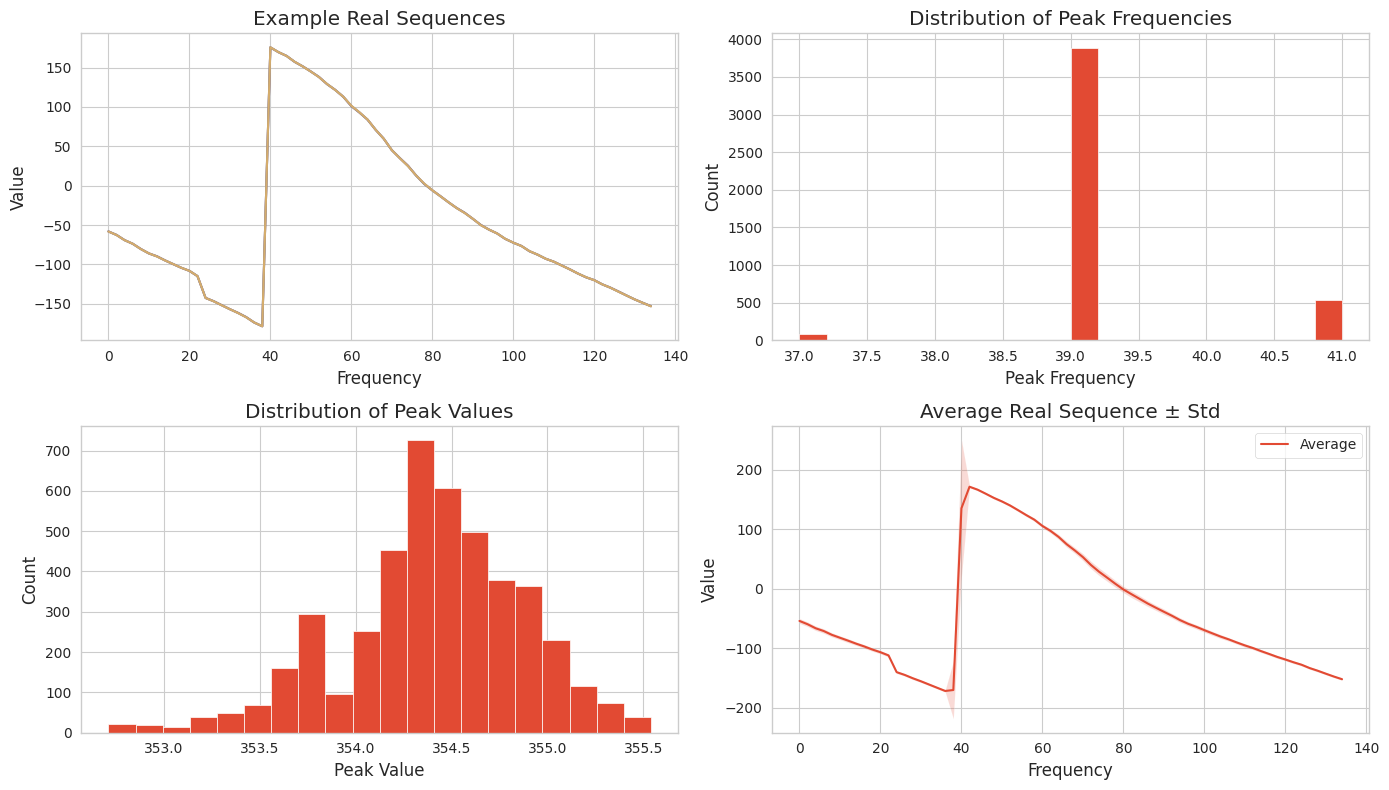

Data analysis completed.
generating synthetic data
Generating 300000 synthetic sequences...


Generating sequences: 100%|██████████| 300000/300000 [00:44<00:00, 6769.50it/s]


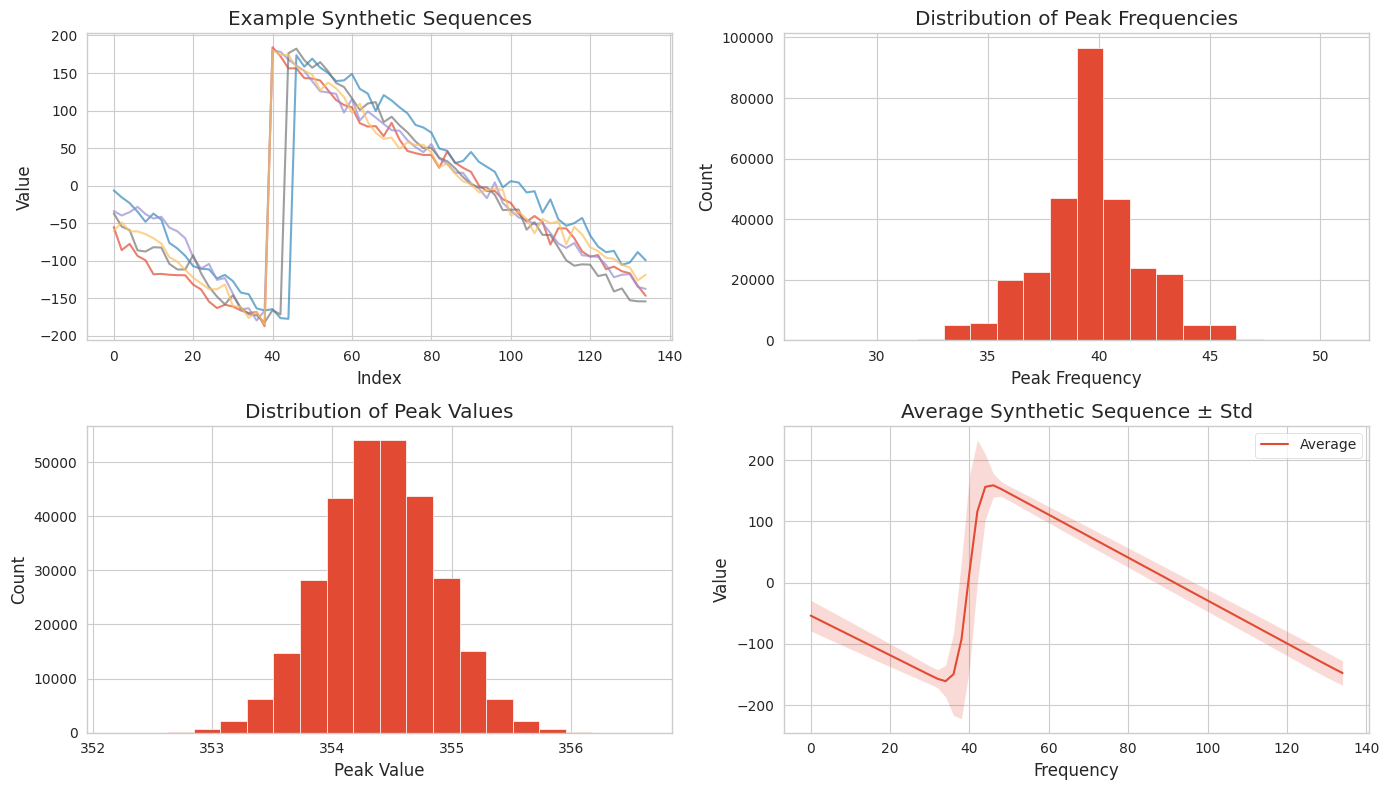

Synthetic data generation completed.
Starting data preprocessing...


Normalizing sequences: 100%|██████████| 300000/300000 [02:17<00:00, 2181.39it/s]


1.0395003376591678e-15
1.0
Train shape: (240000, 68, 1), Test shape: (60000, 68, 1)


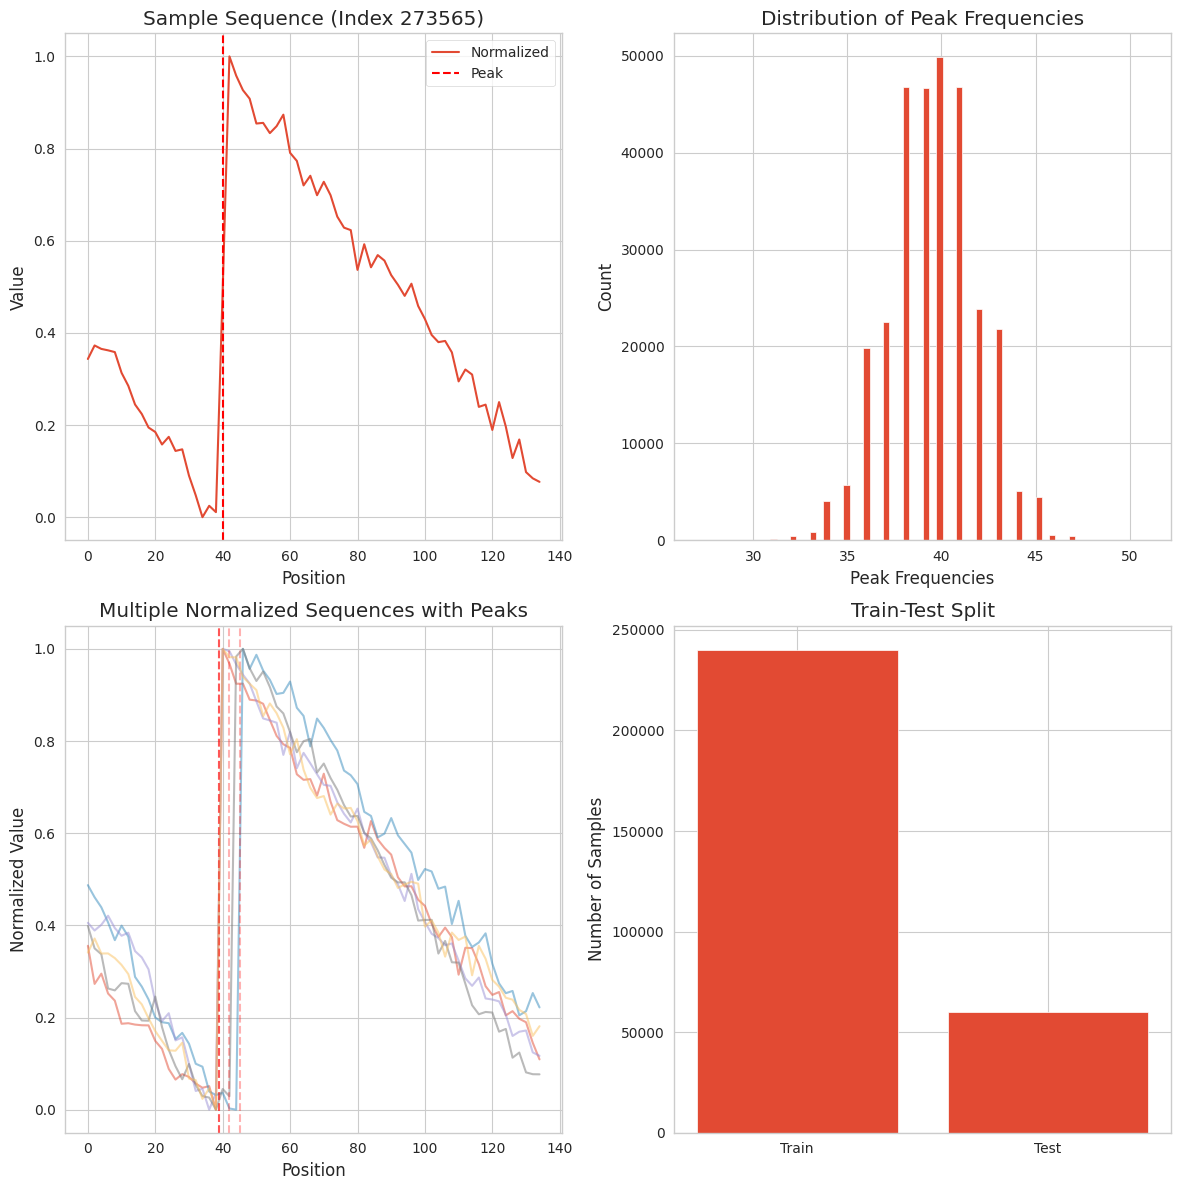

Preprocessing completed.
Creating single-output CNN model...
Model architecture created successfully!


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 68, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 68, 128)        │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 22, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │       229,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ peak_frequency_output (Dense)   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 488,321 (1.86 MB)

 Trainable params: 486,913 (1.86 MB)

 Non-trainable params: 1,408 (5.50 KB)

fitting the model
Starting model training...
Epoch 1/256
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.9051 - mae: 0.6466
Epoch 1: val_loss improved from inf to 0.94921, saving model to /content/drive/MyDrive/OstadSharif/ADVANCEDBPSRGRS/models/best_model.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 29s 294ms/step - loss: 0.8979 - mae: 0.6429 - val_loss: 0.9492 - val_mae: 0.7409 - learning_rate: 0.0010 - lr: 0.0010
Epoch 2/256
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1708 - mae: 0.2106
Epoch 2: val_loss improved from 0.94921 to 0.89045, saving model to /content/drive/MyDrive/OstadSharif/ADVANCEDBPSRGRS/models/best_model.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.1706 - mae: 0.2103 - val_loss: 0.8905 - val_mae: 0.7207 - learning_rate: 0.0010 - lr: 0.0010
Epoch 3/256
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1513 - mae: 0.1832
Epoch 3: val_loss improved from 0.89045 to 0.81570, saving model to /content/drive/MyDrive/OstadSharif/ADVANCEDBPSRGRS/models/best_model.kera

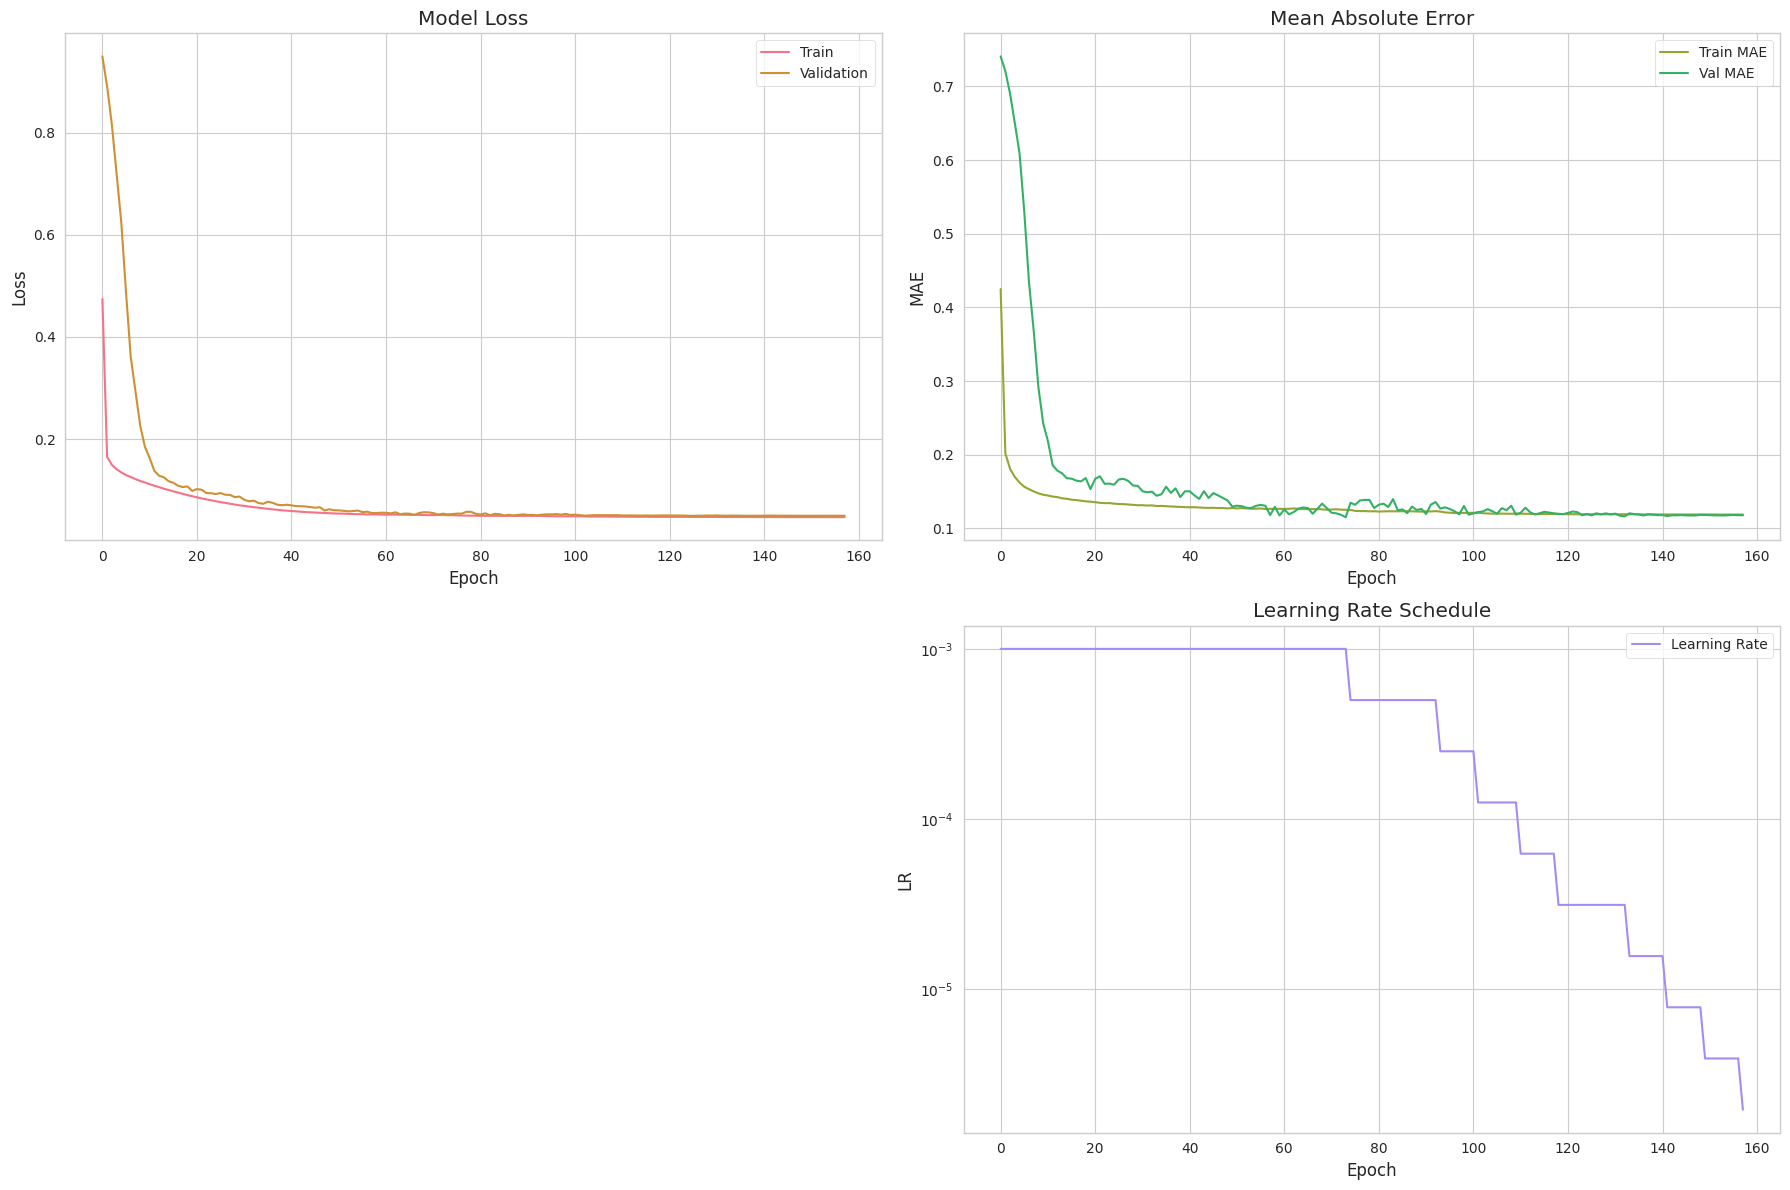

Training completed.
Pipeline completed.


In [ ]:
model, history = full_pipeline(real_bps, model_path=MODEL_PATH, logs_dir_path=LOG_DIR_PATH, scaler_path=SCALER_DIR_PATH, epochs=256, batch_size=4096, synth_n=300000)

Starting model evaluation...
Loading BPS data from /content/drive/MyDrive/OstadSharif/ADVANCEDBPSRGRS/data/BPS_raw.txt...
Loaded data shape: (68, 4501)
Successfully loaded model and data. Found 4501 samples.


Normalizing real data: 100%|██████████| 4501/4501 [00:01<00:00, 2643.52it/s]


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Starting data analysis...


Calculating sequence stats: 100%|██████████| 4501/4501 [00:00<00:00, 33317.62it/s]


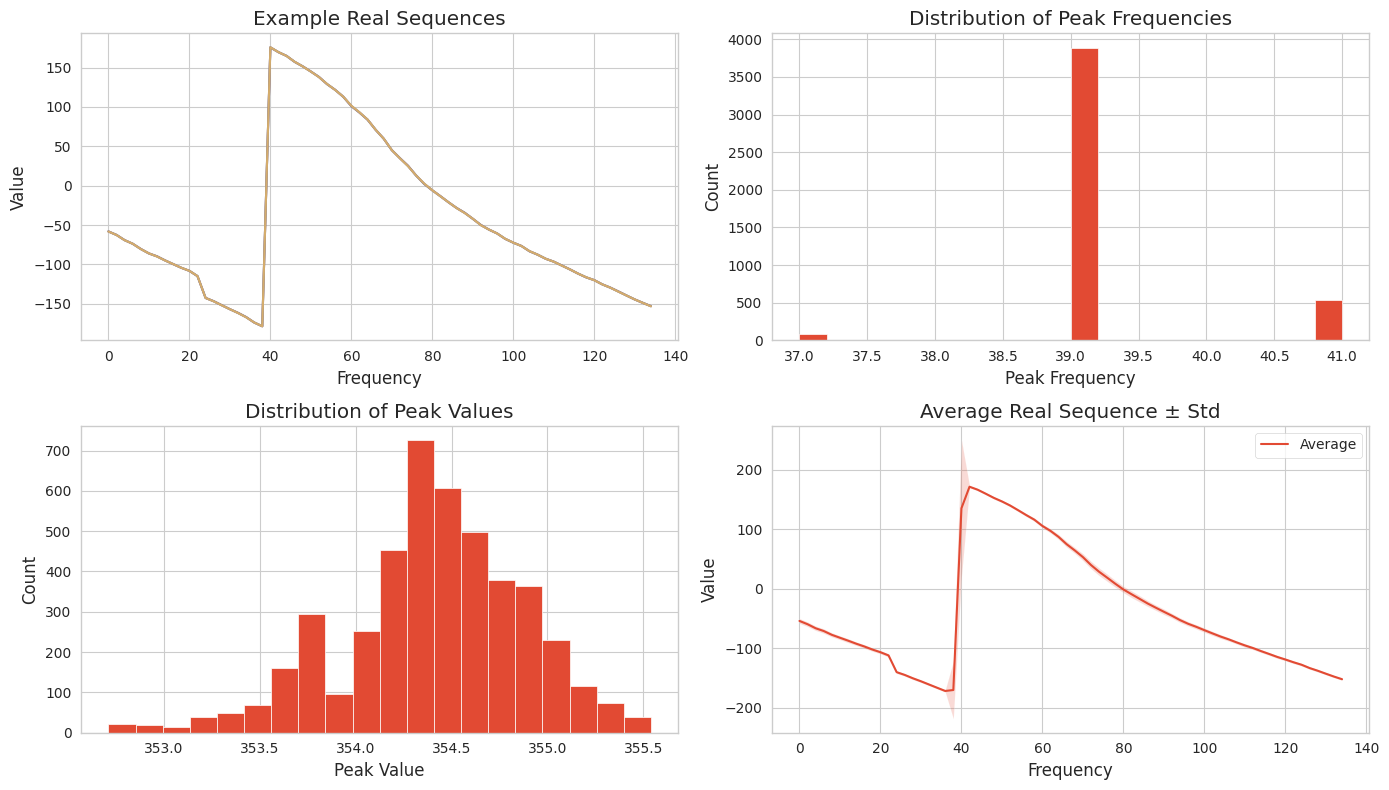

Data analysis completed.


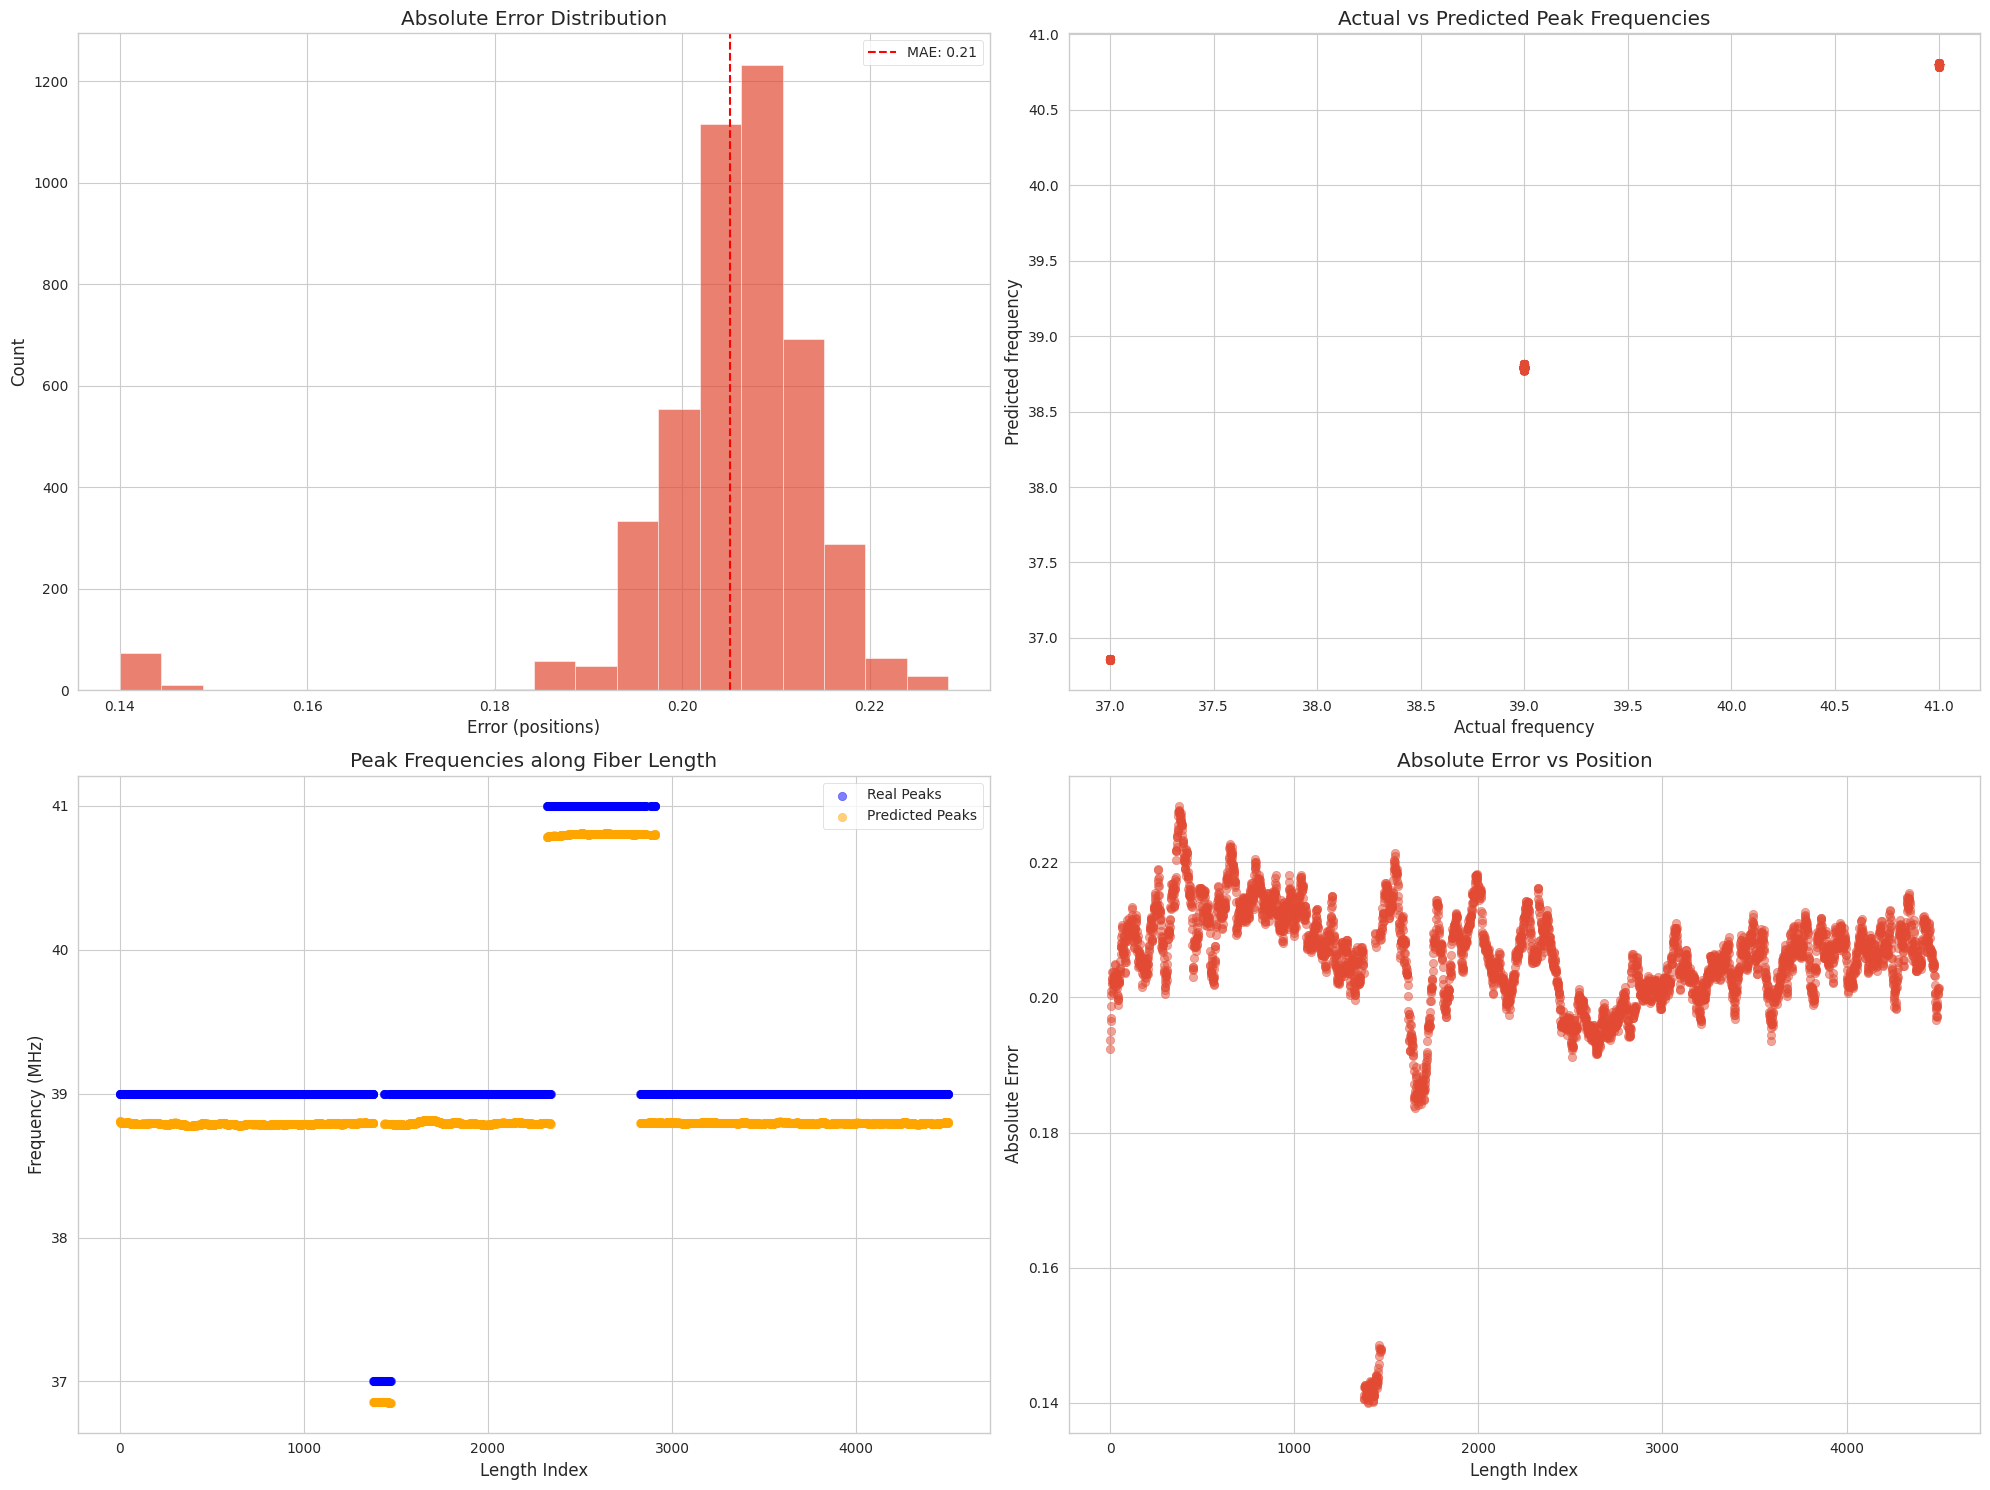


BPS Model Evaluation Summary
Accuracy (±1 position): 100.00%
Mean Absolute Error: 0.21 ± 0.01 positions
Maximum Error: 0.23 positions
Correlation: 0.9999
Evaluation completed.


In [ ]:
evaluation_results = evaluate_bps_model(model_path=MODEL_PATH, real_bps_path=BPS_RAW_TXT_PATH, scaler_path=SCALER_DIR_PATH)